<a href="https://colab.research.google.com/github/ktichola/ML-and-DL-to-Gravitational-waves-analysis/blob/main/Kyriaki_4_WaveNet50_TFresnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gravity-spy-gravitational-waves:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F433366%2F823552%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240506%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240506T035217Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1f3da07cfeec71f19c56f4d2c3a156612a88a23f0c0c2b7cdf29a716792f7afc2fd2d0695e09533d2f73559bff5ba6c87a384ade87103d8ce23688ea278bf901554872db416a458c4105ad38389b2658238c837ca3e990325085800a3e7ede93a6c7cc4ef3ff40297a0b1e7ecb76a2157b5c04e348fbb1040fc8fbaa44c784f34feeaf4efefda924f2e86c44a0a5517795b6090f40e4d964f5ee658b2a7be143587d293f99167668ae80e1d1ce5c20ca487fe7db6ab5bde6cb51a8730bf6a9199ae0bdff02a6a854055fe5b36f57ddef235489c9d30bbac0055d0211b6a389807dfa89b3da483cec3f76fdbfaa60532cdd4f47a8ffc9c354a26a08b043869aef'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim

import torchvision

In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor()
])

In [ ]:
trainset = torchvision.datasets.ImageFolder("../input/gravity-spy-gravitational-waves/train/train" , transform = transforms)
testset = torchvision.datasets.ImageFolder("../input/gravity-spy-gravitational-waves/test/test" , transform = transforms)

In [ ]:
# We are going to use a small part of the training set as testset
split_ratio = 0.1 # i.e 10% of the 389 images -> ~39 images
from torch.utils.data import SubsetRandomSampler
size = len(trainset) # Number of validation images
no_idxs = int(np.ceil(size * split_ratio))
idxs = list(range(size))
np.random.seed(3) # Setting a seed value so that we get the same random values everytime we run the model
np.random.shuffle(idxs)

test_idxs = idxs[:no_idxs]
train_idxs = idxs[no_idxs:]

print("Len of train : ", len(train_idxs))
print()
print("Len of test  :" , len(test_idxs))
print()
print("% of valid data : ",len(test_idxs) / len(train_idxs) * 100)

train_sampler = SubsetRandomSampler(train_idxs)
test_sampler  = SubsetRandomSampler(test_idxs)

# Now we have train , test and valid sets

Len of train :  20113

Len of test  : 2235

% of valid data :  11.112215979714613


In [ ]:
batch_size = 32

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , sampler = test_sampler)
testloader  = torch.utils.data.DataLoader(testset , batch_size=batch_size)

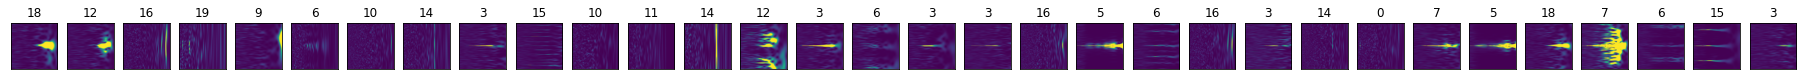

In [ ]:
images , labels = iter(trainloader).next()
images , labels = images.numpy() , labels.numpy()

fig = plt.figure(figsize = (32,32))

for i in range(batch_size):
    ax = fig.add_subplot(1 , batch_size , i+1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(np.squeeze(images[i]) , (2,1,0)))
    ax.set_title(labels[i])

In [ ]:
trainset.classes

['1080Lines',
 '1400Ripples',
 'Air_Compressor',
 'Blip',
 'Chirp',
 'Extremely_Loud',
 'Helix',
 'Koi_Fish',
 'Light_Modulation',
 'Low_Frequency_Burst',
 'Low_Frequency_Lines',
 'No_Glitch',
 'None_of_the_Above',
 'Paired_Doves',
 'Power_Line',
 'Repeating_Blips',
 'Scattered_Light',
 'Scratchy',
 'Tomte',
 'Violin_Mode',
 'Wandering_Line',
 'Whistle']

In [ ]:
import sklearn.preprocessing
enc = sklearn.preprocessing.OrdinalEncoder()

In [ ]:
classes = enc.fit_transform(np.array(trainset.classes).reshape(-1,1))

In [ ]:
model = torchvision.models.resnet50(pretrained = True)
for params in model.parameters():
    params.requires_grad = False
model.fc = nn.Linear(2048 , len(classes))
model.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
lr = 3e-3
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters() , lr = lr , momentum=0.9)

In [ ]:
epochs = 20
print_every = 30
min_valid_loss = np.inf
trainloss = []
validloss = []

for epoch in range(epochs):
  train_loss = 0.0
  valid_loss = 0.0

  model.train() # Setting the model to train mode
  for batch_i , (images , target) in enumerate(trainloader):
    images = images.cuda() #Moving the images to GPU
    target = target.cuda() #Moving the labels to GPU
    ############ Training the model ################
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs , target)
    loss.backward()
    optimizer.step()
    train_loss =  train_loss + ((1 / (batch_i + 1)) * (loss.data - train_loss))
    trainloss.append(train_loss)

  model.eval() # Setting the model to eval mode
  for batch_i , (images , target) in enumerate(validloader):
    images = images.cuda()
    target = target.cuda()
    ############# Validating the model ##############
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs , target)
    valid_loss = valid_loss + ((1 / (batch_i + 1)) * (loss.data - valid_loss))
    validloss.append(valid_loss)

  print("epoch : {} , Training Loss : {} , Validation Loss : {}".format(epoch+1 , train_loss , valid_loss))

  if valid_loss < min_valid_loss:
    print("Validation Loss Reduced from {} ---> {}".format(min_valid_loss , valid_loss))
    torch.save(model.state_dict() , "model_tomatos_classifier.pt")
    min_valid_loss = valid_loss

epoch : 1 , Training Loss : 1.3001357316970825 , Validation Loss : 0.964477002620697
Validation Loss Reduced from inf ---> 0.964477002620697
epoch : 2 , Training Loss : 0.9120748043060303 , Validation Loss : 0.8391076326370239
Validation Loss Reduced from 0.964477002620697 ---> 0.8391076326370239
epoch : 3 , Training Loss : 0.8122060894966125 , Validation Loss : 0.7669930458068848
Validation Loss Reduced from 0.8391076326370239 ---> 0.7669930458068848
epoch : 4 , Training Loss : 0.7558373808860779 , Validation Loss : 0.7426324486732483
Validation Loss Reduced from 0.7669930458068848 ---> 0.7426324486732483
epoch : 5 , Training Loss : 0.7179121971130371 , Validation Loss : 0.6948660612106323
Validation Loss Reduced from 0.7426324486732483 ---> 0.6948660612106323
epoch : 6 , Training Loss : 0.6838304996490479 , Validation Loss : 0.7030324935913086
epoch : 7 , Training Loss : 0.6659983992576599 , Validation Loss : 0.6771332621574402
Validation Loss Reduced from 0.6948660612106323 ---> 0.6

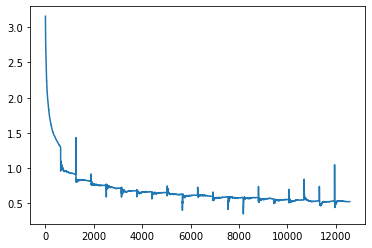

In [ ]:
plt.plot(trainloss)

In [ ]:
 model.load_state_dict(torch.load('model_tomatos_classifier.pt'))

<All keys matched successfully>

In [ ]:
def test(loaders, model, criterion, use_cuda  = True):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [ ]:
test(testloader , model , criterion)

Test Loss: 0.551671


Test Accuracy: 83% (3932/4720)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


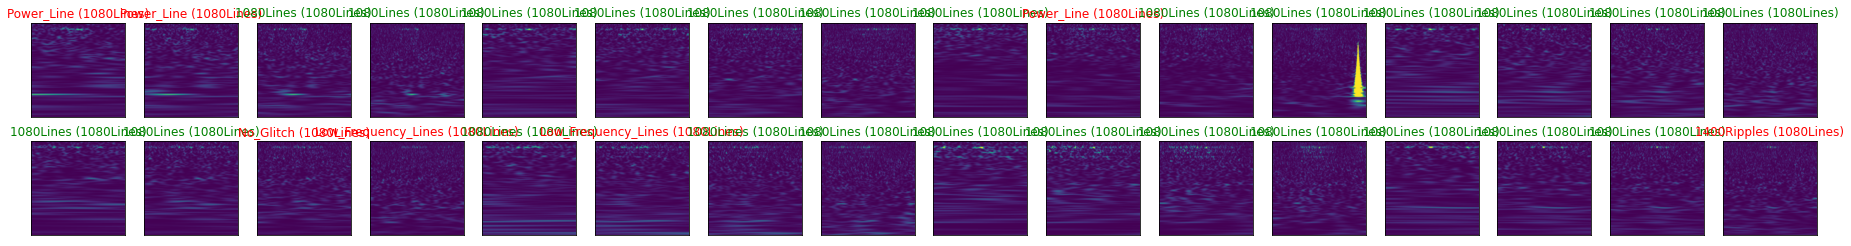

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(32, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx].transpose(1,2,0)), cmap='gray')
    ax.set_title("{} ({})".format(trainset.classes[preds[idx]], trainset.classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [ ]:
import time
dataiter = iter(testloader)
images, labels = dataiter.next()
# get predictions
start = time.time()
preds = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
end = time.time()
print("Inference time : {} ms" .format((end - start)*1000))